### EDA
Notebook to explore data set, filter for clustering, and visualizations to aid in clustering

In [1]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath('..'))
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import src.processing.data_processor as dp

In [3]:
processor = dp.UFCDataProcessor('../data/raw/')
df = processor.process_data()

INFO:src.processing.data_processor:DataProcessor initialized with data path: ../data/raw/
INFO:src.processing.data_processor:Starting full data processing pipeline...
INFO:src.processing.data_processor:Data loaded successfully. 8250 events, 2598 fighters, 8250 fights.
INFO:src.processing.data_processor:Preparing fight-level data...
INFO:src.processing.data_processor:Prepared fighter-level data with 16500 records.
INFO:src.processing.data_processor:Aggregating fighter statistics...
INFO:src.processing.data_processor:Aggregated data for 2598 fighters
INFO:src.processing.data_processor:Calculating derived metrics...
INFO:src.processing.data_processor:Merging fighter details...
INFO:src.processing.data_processor:Processing complete! Final dataset shape: (2598, 77)


In [4]:
df.columns

Index(['id', 'total_UFC_fights', 'UFC_wins', 'UFC_losses', 'match_time_sec',
       'total_rounds', 'kd', 'sig_stlanded', 'sig_statmpted', 'total_stlanded',
       'total_statmpted', 'td_landed', 'td_atmpted', 'ctrl', 'head_landed',
       'head_atmpted', 'body_landed', 'body_atmpted', 'leg_landed',
       'leg_atmpted', 'dist_landed', 'dist_atmpted', 'clinch_landed',
       'clinch_atmpted', 'ground_landed', 'ground_atmpted', 'suatt', 'name',
       'division', 'wins_by_dq_overturned', 'wins_by_decision',
       'wins_by_ko_tko', 'wins_by_submission', 'losses_by_dq_overturned',
       'losses_by_decision', 'losses_by_ko_tko', 'losses_by_submission',
       'career_sig_st_acc', 'career_total_st_acc', 'career_td_acc',
       'career_head_acc', 'career_body_acc', 'career_leg_acc',
       'career_dist_acc', 'career_clinch_acc', 'career_ground_acc',
       'sig_st_landed_per_min', 'td_landed_per_min', 'kd_per_min',
       'avg_fight_time_sec', 'win_percentage', 'finish_rate', 'ko_tko_rate'

In [5]:
# df.shape # (2598, 77)

# Check for missing values
df.loc[df.isnull().any(axis=1)].shape # (1242, 77) out of 2598 rows have at least one missing value

(1242, 77)

In [6]:
# count missing values per column
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
missing_counts 

# Most common missing value nick name- not important for clustering

# Age can be dropped- not important for clustering

# Need to filter or impute very important variables - stance, reach, height - most likely to be important for clustering

nick_name    916
reach        655
dob          156
stance        77
height        21
weight        18
dtype: int64

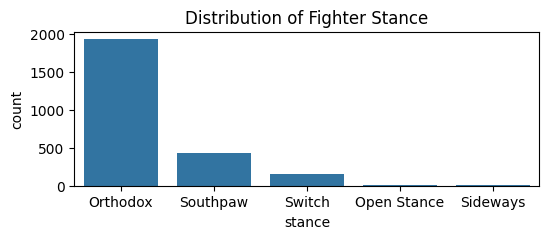

In [7]:
# visualize stance distribution
plt.figure(figsize=(6,2))
sns.countplot(data=df, x='stance', order=df['stance'].value_counts().index)
plt.title('Distribution of Fighter Stance');

In [8]:
# Reclassify southpaw and switch stances as orthodox for simplicity
df['stance'] = df['stance'].replace({'Open Stance':'Orthodox', 'Sideways':'Orthodox'})

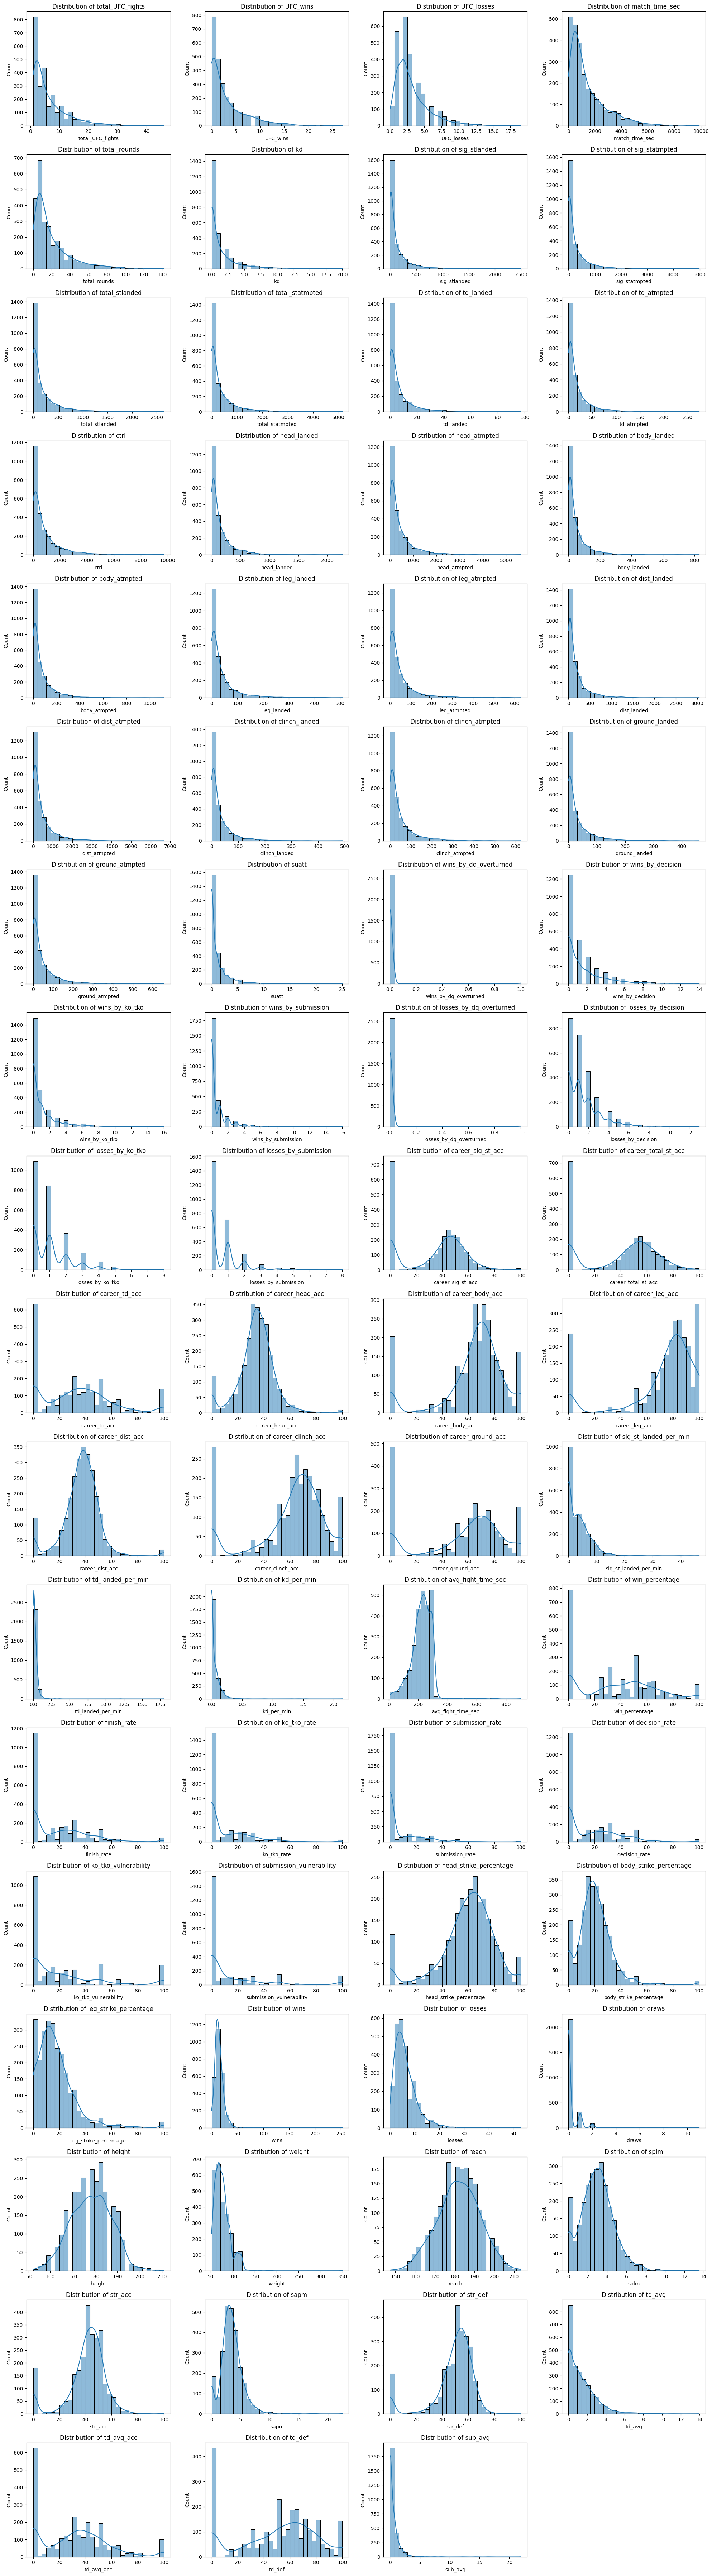

In [9]:
# Select numeric columns for distribution visualization
numeric_cols = df.select_dtypes(include=['number']).columns

# Set up the grid for subplots
num_cols = len(numeric_cols)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)  # Creates a grid with up to 4 plots per row

fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot distributions
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [15]:
# Check for impossible values in dataset
df[['name','draws', 'UFC_wins', 'UFC_losses', 'total_UFC_fights', 'wins_by_Other']].loc[df['UFC_losses'] + df['UFC_wins'] != df['total_UFC_fights']]

# Issue with no contest affecting wins/losses 

KeyError: "['wins_by_Other'] not in index"

In [13]:
# How many fighters have less than 5 fights?
df.loc[df['total_UFC_fights'] < 5].shape # 1403 fighters have less than 5 fights

(1403, 77)